<a href="https://colab.research.google.com/github/Tony363/Chartmetric_Analysis/blob/master/Chartmetric_DataConsolidation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
  forcasting followers and listeners over 6 month regression
  model around followers and listeners
  cut off followers lower than 10000
  cut off listeners 100000
  popularity cut off 40

  *create new metric(artist score) off of populurity,followers, listeners <- these 3 variables
  homepage and dashboard(UI)
  step 1 <- visual representation of what the platform looks like (basic sustainable platform)
    - barebones UI
    - with plot metrics
  -heursticals timeseries giving it a weights average and aggregate
    (proof of concept first)<-small easy project easy money
  -only use first row of each artist because lack of prevalence
  - diff var / value    
  """

In [ ]:
!unzip 266_Erick\ Morillo.zip -d path_to_directory

Archive:  266_Erick Morillo.zip
  inflating: path_to_directory/1027_Govinda.csv  
  inflating: path_to_directory/1105_Ike Reilly.csv  
  inflating: path_to_directory/1182_John Travolta.csv  
  inflating: path_to_directory/121_311.csv  
  inflating: path_to_directory/1210_Bounty Killer.csv  
  inflating: path_to_directory/1215_Nappy Roots.csv  
  inflating: path_to_directory/1231_Chaka Demus & Pliers.csv  
  inflating: path_to_directory/1252_Bloodstone.csv  
  inflating: path_to_directory/1267_Patra.csv  
  inflating: path_to_directory/1287_Jason Weaver.csv  
  inflating: path_to_directory/1290_Susan Egan.csv  
  inflating: path_to_directory/1351_My Chemical Romance.csv  
  inflating: path_to_directory/1430_Biffy Clyro.csv  
  inflating: path_to_directory/1476_Tech N9ne.csv  
  inflating: path_to_directory/149_Godsmack.csv  
  inflating: path_to_directory/1607_Michael BublВ.csv  
  inflating: path_to_directory/1649_Young Disciples.csv  
  inflating: path_to_directory/1676_A Tribe Called

In [ ]:
import glob
import pandas as pd

# get data file names
path =r'/content/path_to_directory'
filenames = glob.glob(path + "/*.csv")

dfs = []
for filename in filenames:
    dfs.append(pd.read_csv(filename))

# Concatenate all data into one DataFrame
big_frame = pd.concat(dfs, ignore_index=True)

In [ ]:
big_frame.to_csv("Chartmetric_Sample_Data.csv")

In [19]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Dec  4 13:24:30 2020

@author: tony
"""

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import random

from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,KFold
from scipy import stats  
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import itertools

# load in main database of songs and attributes
def load_data():
    df = pd.read_csv("Chartmetric_Sample_Data.csv")
    df.drop('Unnamed: 0',axis=1,inplace=True)
    df.set_index("Chartmetric_ID",inplace=True)
    return df

# set some display options so easier to view all columns at once
def set_view_options(max_cols=50, max_rows=50, max_colwidth=9, dis_width=250):
    pd.options.display.max_columns = max_cols
    pd.options.display.max_rows = max_rows
    pd.set_option('max_colwidth', max_colwidth)
    pd.options.display.width = dis_width
    
def rename_columns(df):
    subidx = [df.columns.get_loc(col) for col in df.columns if "Subject" in col] 
    subjects = df.columns[[subidx]]
    df.rename(columns={df.columns[subidx[idx]]:df.iloc[0,subidx[idx]] for idx,sub in enumerate(subidx)},inplace=True)
    for subject,idx in enumerate(range(0,len(df.columns),7)):
        df.rename(columns={sub:df.columns[subidx[subject]]+" "+sub for idx,sub in enumerate(df.columns[idx+1:idx+7])},inplace=True)
    return df

def get_df_info(df):
    # print memory usage
    print(df.memory_usage(),'\n')
    # take an initial look at our data
    print(df.head(),'\n')

    # take a look at the columns in our data set
    print("The columns are:")
    print(df.columns,'\n')

    # look at data types for each
    info = df.info()
    print(info,'\n')

    # take a look at data types, and it looks like we have a pretty clean data set!
    # However, I think the 0 popularity scores might throw the model(s) off a bit.
    print("Do we have any nulls?")
    print(f"Looks like we have {df.isnull().sum().sum()} nulls\n")
    
    subject_col = []
    statsdf = []
    # look at basic metric mapping
    for idx,col in enumerate(df.columns):
        if idx % 7 != 0:
            try:
                stats = df.agg({col:['min','max','median','mean','skew']})
                subject_col.append(col)
                statsdf.append(stats.transpose())
            except Exception as e:
                # print(e)
                continue
    statsdf = pd.concat(statsdf,axis=0,ignore_index=True)
    statsdf.set_index([pd.Index(subject_col)],inplace=True)
    return statsdf,df.info()
    # print(df.agg({col:['min','max','median','skew'] for idx,col in enumerate(df.columns) if idx % 7 != 0}))

# calculate and print more stats from the df
def get_stats(df):
    # print stats for various metrics
    print(f"There are {df.shape[0]} rows")
    print(f"There are {df['track_id'].unique().shape} unique songs")
    print(f"There are {df['artist_name'].unique().shape} unique artists")
    print(f"There are {df['popularity'].unique().shape} popularity scores")
    print(f"The mean popularity score is {df['popularity'].mean()}")
    print(f"There are {df[df['popularity'] > 55]['popularity'].count()} songs with a popularity score > 55")
    print(f"There are {df[df['popularity'] > 75]['popularity'].count()} songs with a popularity score > 75")
    print(f"Only {(df[df['popularity'] > 80]['popularity'].count() / df.shape[0])*100:.2f} % of songs have a popularity score > 80")

def calc_correlations(df, cutoff=0.5):
    corr = df.corr()
    corr_data = corr[corr > cutoff]
    corr_list = df.corr().unstack().sort_values(kind="quicksort",ascending=False)
    return corr_list.drop(corr_list.index[:20]),corr_data

# nice way to truncate the column names to display easier
# can be used with various metrics
def describe_cols(df, L=10):
    '''Limit ENTIRE column width (including header)'''
    # get the max col width
    O = pd.get_option("display.max_colwidth")
    # set max col width to be L
    pd.set_option("display.max_colwidth", L)
    describe = df.rename(columns=lambda x: x[:L - 2] + '...' if len(x) > L else x).describe()
    pd.set_option("display.max_colwidth", O) 
    return describe

# get redundant pairs from DataFrame
def get_redundant_pairs(df):
    '''Get diagonal pairs of correlation matrix and all pairs we'll remove 
    (since pair each is doubled in corr matrix)'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            if df[cols[i]].dtype != 'object' and df[cols[j]].dtype != 'object':
                # print("THIS IS NOT AN OBJECT, YO, so you CAN take a corr of it, smarty!")
                pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=10):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    
    print("The top absolute correlations are:")
    print(au_corr[0:n])
    return au_corr[0:n]
    
# plot a scatter plot
def scatter_plot(df, col_x, col_y):
    plt.scatter(df[col_x], df[col_y], alpha=0.2)
    plt.title(f"{col_x} vs {col_y}")
    plt.xlabel(f"{col_x}")
    plt.ylabel(f"{col_y}")
    plt.show()

def plot_scatter_matrix(df, num_rows):
    scatter_matrix(df[:num_rows], alpha=0.2, figsize=(6, 6), diagonal='kde')
    plt.show()

# initial linear regression function, and plots
def linear_regression_initial(df):
    df = df.copy()
    for col in df.columns:
        X_cols = df.columns.drop(col)
    
        y_col = [col]
    
        X = df[X_cols]
        y = df[y_col]
    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    
        X_train = sm.add_constant(X_train)
    
        # Instantiate OLS model, fit, predict, get errors
        model = sm.OLS(y_train, X_train)
        results = model.fit()
        fitted_vals = results.predict(X_train)
        stu_resid = results.resid_pearson
        residuals = results.resid
        y_vals = pd.DataFrame({'residuals':residuals, 'fitted_vals':fitted_vals, \
                               'stu_resid': stu_resid})
    
        # Print the results
        print(results.summary())
    
        # QQ Plot
        fig, ax = plt.subplots(figsize=(8, 5))
        plt.title(f"QQ Plot-{col} Initial Linear Regression")
        fig = sm.qqplot(stu_resid, line='45', fit=True, ax=ax)
        plt.show()
    
        # Residuals Plot
        y_vals.plot(kind='scatter', x='fitted_vals', y='stu_resid')
        plt.title(f"{col} regression")
        plt.show()

# plot univariate dists for several independent variables
def plot_univ_dists(df, cutoff):
    popularity_cutoff = cutoff
    print('Mean value for Danceability feature for Popular songs: {}'.format(df[df['popularity'] > popularity_cutoff]['danceability'].mean()))
    print('Mean value for Danceability feature for Unpopular songs: {}'.format(df[df['popularity'] < popularity_cutoff]['danceability'].mean()))
    
    fig, ax = plt.subplots(1, 1, figsize=(8,5))
    fig.suptitle('Histograms and Univariate Distributions of Important Features')
    sns.distplot(df[df['popularity'] < popularity_cutoff]['danceability'])
    sns.distplot(df[df['popularity'] > popularity_cutoff]['danceability'])
    plt.show()

    fig, ax = plt.subplots(1, 1, figsize=(8,5))
    sns.distplot(df[df['popularity'] < popularity_cutoff]['valence'])
    sns.distplot(df[df['popularity'] > popularity_cutoff]['valence'])
    plt.show()

    fig, ax = plt.subplots(1, 1, figsize=(8,5))
    sns.distplot(df[df['popularity'] < popularity_cutoff]['acousticness'])
    sns.distplot(df[df['popularity'] > popularity_cutoff]['acousticness'])
    plt.show()

# plot a heatmap of the correlations between features as well as dependent variable
def plot_heatmap(df):
    # note this looks better in jupyter as well
    plt.figure(figsize = (16,6))
    sns.heatmap(df.corr(), cmap="coolwarm", annot=True, )
    plt.show()
  
# plot a confusion matrix
def plot_confusion_matrix(cm, ax, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    """
    font_size = 24
    p = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title,fontsize=font_size)
    
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45, fontsize=16)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes, fontsize=16)
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if i == 1 and j == 1:
            lbl = "(True Positive)"
        elif i == 0 and j == 0:
            lbl = "(True Negative)"
        elif i == 1 and j == 0:
            lbl = "(False Negative)"
        elif i == 0 and j == 1:
            lbl = "(False Positive)"
        ax.text(j, i, "{:0.2f} \n{}".format(cm[i, j], lbl),
                 horizontalalignment="center", size = font_size,
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    ax.set_ylabel('True',fontsize=font_size)
    ax.set_xlabel('Predicted',fontsize=font_size)

# Create a basic logistic regression
def basic_logistic_regression(df, cutoff=55, rand=0, sig_only=False):
    df = df.copy()

    if sig_only == True:
        X, y = return_X_y_logistic_sig_only(split_sample_combine(df, cutoff=cutoff, rand=rand))
        X = standardize_X_sig_only(X)

    else:
        X, y = return_X_y_logistic(split_sample_combine(df, cutoff=80, rand=rand))
        X = standardize_X(X)

    X_const = add_constant(X, prepend=True)

    logit_model = Logit(y, X_const).fit()
    
    print(logit_model.summary())

    return logit_model

# various data standardization and X/y split functions for logisitic reression
# based on the columns you want to standardize and return
def return_X_y_logistic(df):
    df = df.copy()

    # define columns to use for each
    X_cols = df.columns

    # use 1's and 0's for logistic
    y_col = df.columns[0]

    # split into X and y
    X = df[X_cols]
    y = df[y_col]

    return X, y

def logistic_regression_with_kfold(df, cutoff=55, rand=0, sig_only=False):
    df = df.copy()
    
    if sig_only == True:
        X, y = return_X_y_logistic_sig_only(split_sample_combine(df, cutoff=cutoff, rand=rand))
        X = standardize_X_sig_only(X)

    else:
        X, y = return_X_y_logistic(split_sample_combine(df, cutoff=cutoff, rand=rand))
        X = standardize_X(X)

    X = X.values
    y = y.values.ravel()

    classifier = LogisticRegression()

    # before kFold
    y_predict = classifier.fit(X, y).predict(X)
    y_true = y
    accuracy_score(y_true, y_predict)
    print(f"accuracy: {accuracy_score(y_true, y_predict)}")
    print(f"precision: {precision_score(y_true, y_predict)}")
    print(f"recall: {recall_score(y_true, y_predict)}")
    print(f"The coefs are: {classifier.fit(X,y).coef_}")

    # with kfold
    kfold = KFold(len(y))

    accuracies = []
    precisions = []
    recalls = []

    for train_index, test_index in kfold:
        model = LogisticRegression()
        model.fit(X[train_index], y[train_index])

        y_predict = model.predict(X[test_index])
        y_true = y[test_index]

        accuracies.append(accuracy_score(y_true, y_predict))
        precisions.append(precision_score(y_true, y_predict))
        recalls.append(recall_score(y_true, y_predict))

    print(f"accuracy: {np.average(accuracies)}")
    print(f"precision: {np.average(precisions)}")
    print(f"recall: {np.average(recalls)}")

def group_time(df):
    timeidx = [df.columns.get_loc(col) for col in df.columns if "timestp" in col] 
    time = df.iloc[:,timeidx]
    print(timeidx)
    df = df.drop(df.columns[timeidx[1:]],axis=1).reset_index().groupby(['followers timestp']).first()
    return df

model around followers and listeners


In [20]:
    # data clean
    df = load_data()  
    set_view_options(max_cols=50, max_rows=50, max_colwidth=40, dis_width=250)
    duplicated = True in df.columns.duplicated()
    print(f"duplicate columns: {duplicated}")
    df = rename_columns(df)
    df = group_time(df)
    df

duplicate columns: False
[6, 13, 20, 27]


/usr/local/lib/python3.6/dist-packages/pandas/core/indexes/base.py:4111: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


,Chartmetric_ID,followers,followers weekly_diff,followers weekly_diff_percent,followers monthly_diff,followers monthly_diff_percent,followers value,popularity,popularity weekly_diff.1,popularity weekly_diff_percent.1,popularity monthly_diff.1,popularity monthly_diff_percent.1,popularity value.1,listeners,listeners weekly_diff.2,listeners weekly_diff_percent.2,listeners monthly_diff.2,listeners monthly_diff_percent.2,listeners value.2,followers_to_listeners_ratio,followers_to_listeners_ratio weekly_diff.3,followers_to_listeners_ratio weekly_diff_percent.3,followers_to_listeners_ratio monthly_diff.3,followers_to_listeners_ratio monthly_diff_percent.3,followers_to_listeners_ratio value.3
followers timestp,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-01T00:00:00.000Z,Lyrycyst,followers,1.0,0.1887,2.0,0.3774,509.0,popularity,0.0,0.0,0.0,0.0,3.0,listeners,-11.0,-7.4324,-35.0,-21.4724,190.0,followers_to_listeners_ratio,0.314962,8.795171,0.937502,28.832594,267.89
2020-01-02T00:00:00.000Z,Sam & Dave,followers,504.0,0.2325,2541.0,1.1835,180028.0,popularity,0.0,0.0,0.0,0.0,61.0,listeners,-18201.0,-1.0785,-56210.0,-3.2574,1462956.0,followers_to_listeners_ratio,0.001702,1.325225,0.005711,4.590024,12.31
2020-01-03T00:00:00.000Z,Lyrycyst,followers,1.0,0.1887,2.0,0.3774,509.0,popularity,0.0,0.0,0.0,0.0,3.0,listeners,-11.0,-7.4324,-35.0,-21.4724,187.0,followers_to_listeners_ratio,0.314962,8.795171,0.937502,28.832594,272.19
2020-01-04T00:00:00.000Z,Sam & Dave,followers,504.0,0.2325,2541.0,1.1835,180274.0,popularity,0.0,0.0,0.0,0.0,62.0,listeners,-18201.0,-1.0785,-56210.0,-3.2574,1477611.0,followers_to_listeners_ratio,0.001702,1.325225,0.005711,4.590024,12.20
2020-01-05T00:00:00.000Z,Lyrycyst,followers,1.0,0.1887,2.0,0.3774,508.0,popularity,0.0,0.0,0.0,0.0,3.0,listeners,-11.0,-7.4324,-35.0,-21.4724,193.0,followers_to_listeners_ratio,0.314962,8.795171,0.937502,28.832594,263.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-28T00:00:00.000Z,Sam & Dave,followers,504.0,0.2325,2541.0,1.1835,196209.0,popularity,0.0,0.0,0.0,0.0,60.0,listeners,-18201.0,-1.0785,-56210.0,-3.2574,1675737.0,followers_to_listeners_ratio,0.001702,1.325225,0.005711,4.590024,11.71
2020-05-29T00:00:00.000Z,Sam & Dave,followers,504.0,0.2325,2541.0,1.1835,196209.0,popularity,0.0,0.0,0.0,0.0,60.0,listeners,-18201.0,-1.0785,-56210.0,-3.2574,1675737.0,followers_to_listeners_ratio,0.001702,1.325225,0.005711,4.590024,11.71
2020-05-30T00:00:00.000Z,Sam & Dave,followers,504.0,0.2325,2541.0,1.1835,196890.0,popularity,0.0,0.0,0.0,0.0,60.0,listeners,-18201.0,-1.0785,-56210.0,-3.2574,1704301.0,followers_to_listeners_ratio,0.001702,1.325225,0.005711,4.590024,11.55


Index                                                  159168
followers                                              159168
followers weekly_diff                                  159168
followers weekly_diff_percent                          159168
followers monthly_diff                                 159168
followers monthly_diff_percent                         159168
followers value                                        159168
followers timestp                                      159168
popularity                                             159168
popularity weekly_diff.1                               159168
popularity weekly_diff_percent.1                       159168
popularity monthly_diff.1                              159168
popularity monthly_diff_percent.1                      159168
popularity value.1                                     159168
popularity timestp.1                                   159168
listeners                                              159168
listener

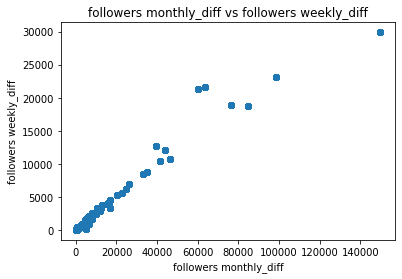

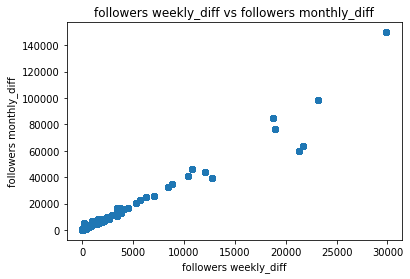

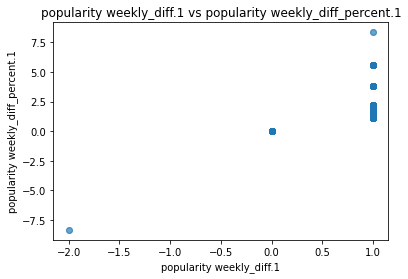

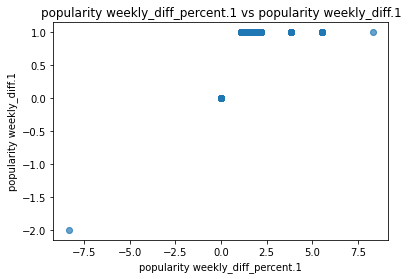

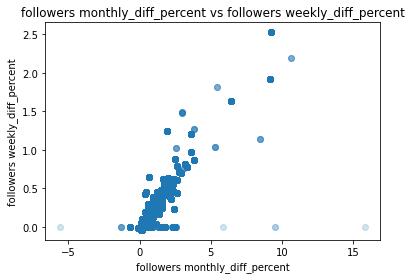

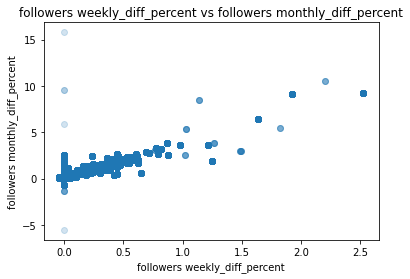

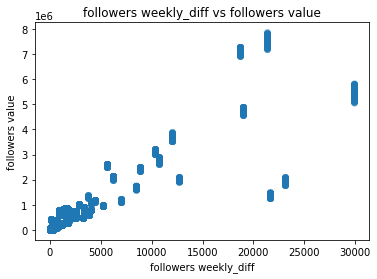

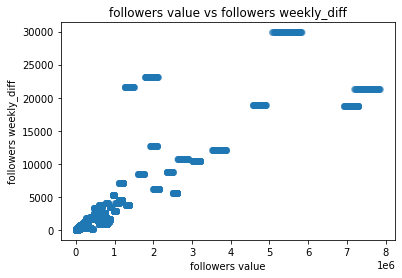

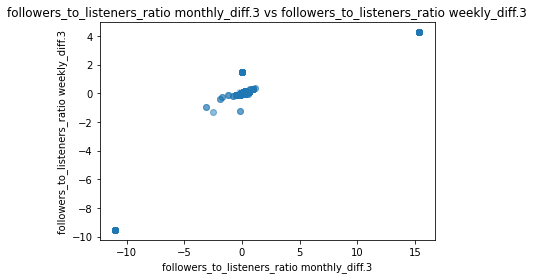

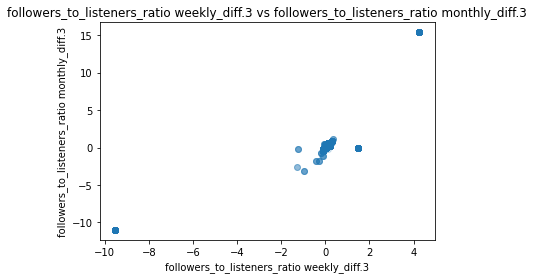

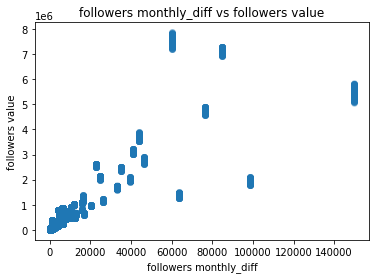

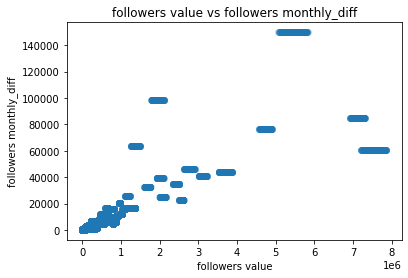

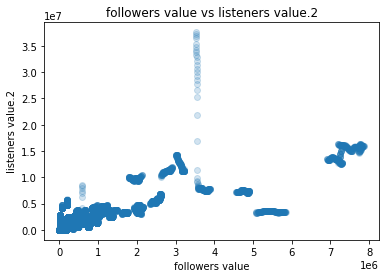

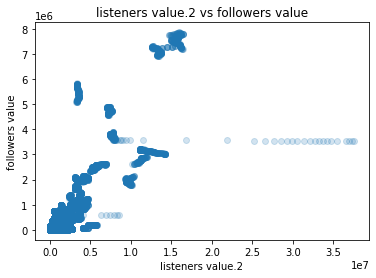

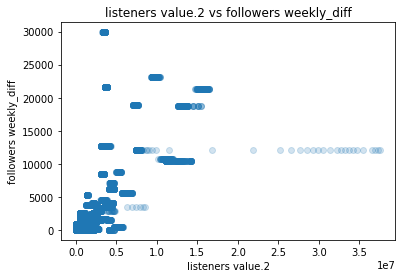

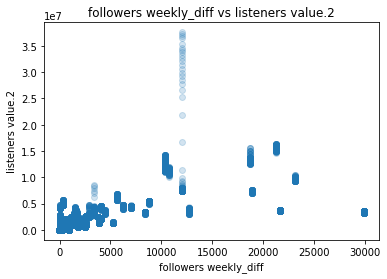

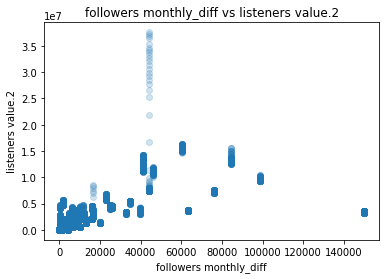

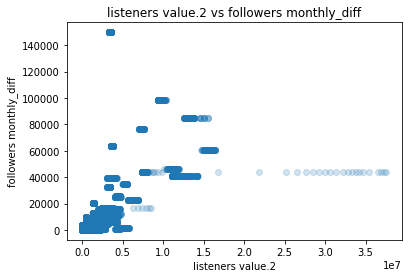

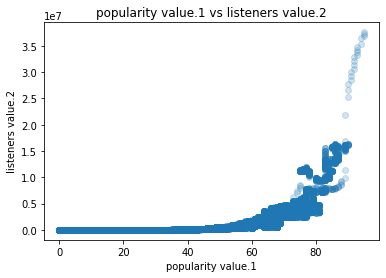

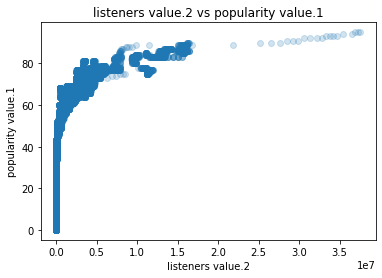

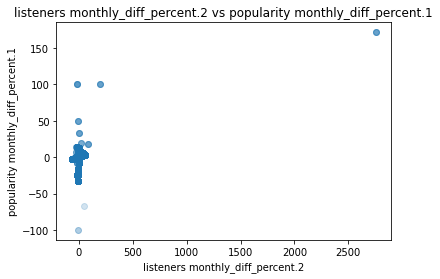

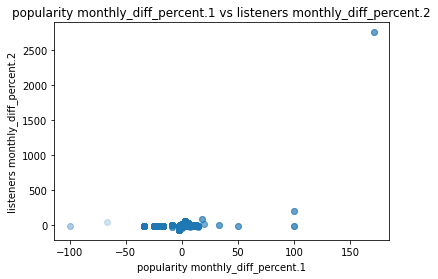

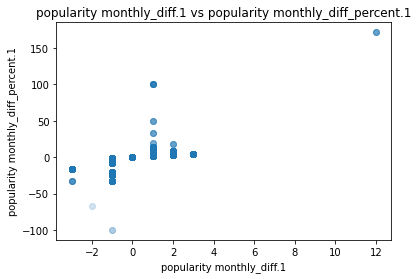

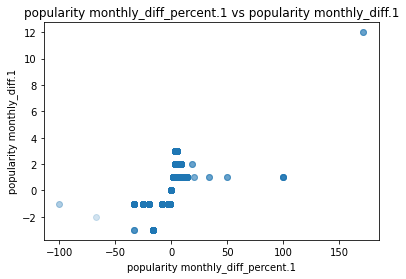

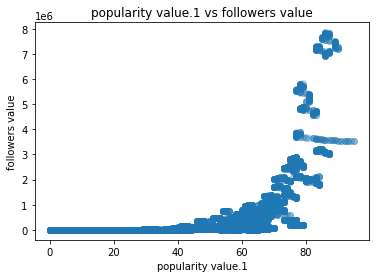

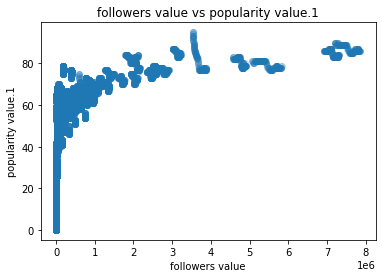

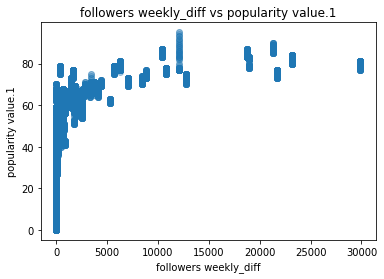

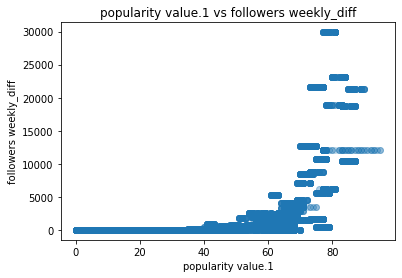

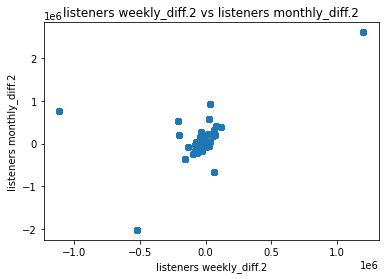

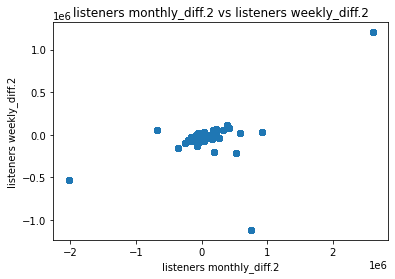

In [6]:
# prelim insights
statsdf,info = get_df_info(df)
print()
corr_list,corr_data = calc_correlations(df)
plot_index = corr_list[corr_list > 0.5].index
for plot in plot_index:
    scatter_plot(df,plot[0],plot[1])
describe = describe_cols(df,10)
print()

The top absolute correlations are:
followers weekly_diff                       followers monthly_diff                                0.978223
listeners weekly_diff_percent.2             followers_to_listeners_ratio weekly_diff_percent.3    0.961573
popularity weekly_diff.1                    popularity weekly_diff_percent.1                      0.906725
followers weekly_diff_percent               followers monthly_diff_percent                        0.873272
followers weekly_diff                       followers value                                       0.867858
followers_to_listeners_ratio weekly_diff.3  followers_to_listeners_ratio monthly_diff.3           0.855333
followers monthly_diff                      followers value                                       0.848507
followers value                             listeners value.2                                     0.831162
followers weekly_diff                       listeners value.2                                     0.728059
fo

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4535: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


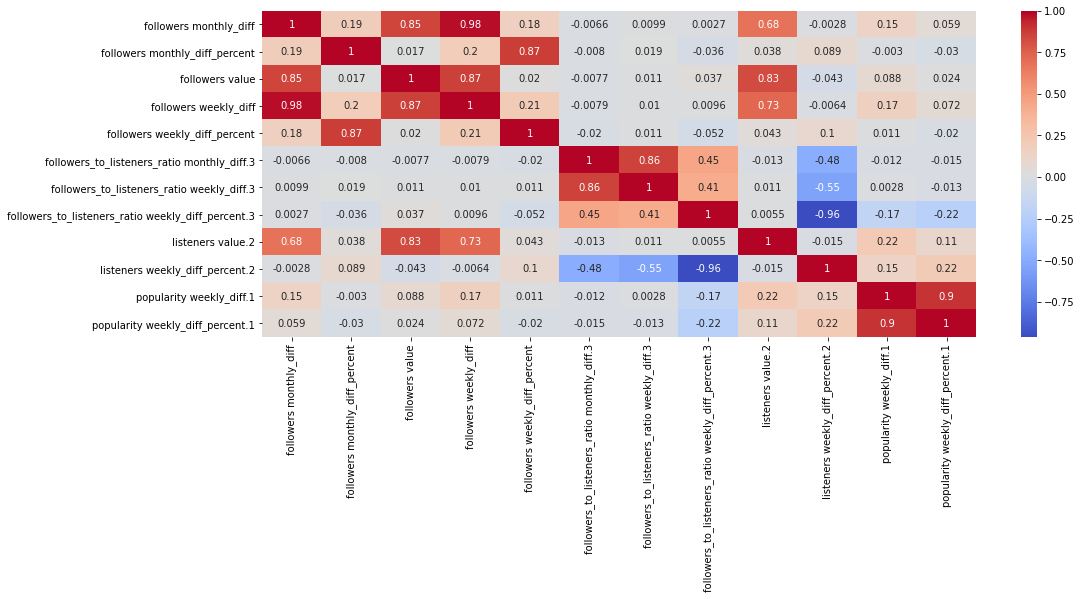

In [7]:
# Data prep
au_corr = get_top_abs_correlations(df, 10)
train_cols = np.unique(np.asarray([au_corr.index])[0].flatten())
dtrain = df[train_cols]
dtrain.fillna(dtrain.mean(),inplace=True)
plot_heatmap(dtrain)

                              OLS Regression Results                              
Dep. Variable:     followers monthly_diff   R-squared:                       0.963
Model:                                OLS   Adj. R-squared:                  0.963
Method:                     Least Squares   F-statistic:                 3.501e+04
Date:                    Mon, 07 Dec 2020   Prob (F-statistic):               0.00
Time:                            06:09:04   Log-Likelihood:            -1.4461e+05
No. Observations:                   14922   AIC:                         2.893e+05
Df Residuals:                       14910   BIC:                         2.893e+05
Df Model:                              11                                         
Covariance Type:                nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

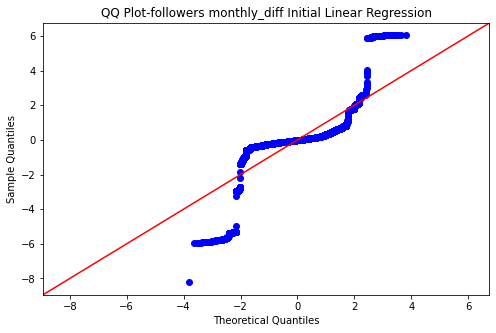

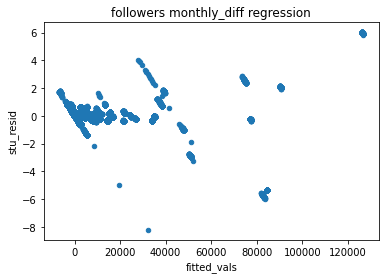

                                  OLS Regression Results                                  
Dep. Variable:     followers monthly_diff_percent   R-squared:                       0.775
Model:                                        OLS   Adj. R-squared:                  0.775
Method:                             Least Squares   F-statistic:                     4675.
Date:                            Mon, 07 Dec 2020   Prob (F-statistic):               0.00
Time:                                    06:09:04   Log-Likelihood:                -9957.1
No. Observations:                           14922   AIC:                         1.994e+04
Df Residuals:                               14910   BIC:                         2.003e+04
Df Model:                                      11                                         
Covariance Type:                        nonrobust                                         
                                                         coef    std err          t      P

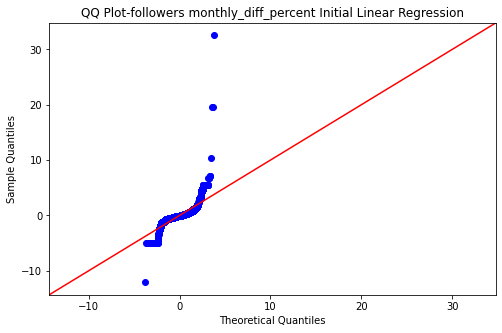

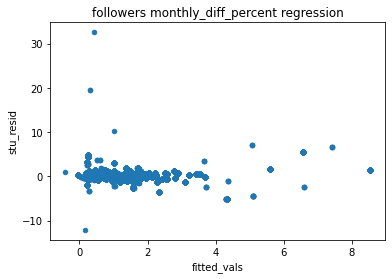

                            OLS Regression Results                            
Dep. Variable:        followers value   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     8814.
Date:                Mon, 07 Dec 2020   Prob (F-statistic):               0.00
Time:                        06:09:05   Log-Likelihood:            -2.1494e+05
No. Observations:               14922   AIC:                         4.299e+05
Df Residuals:                   14910   BIC:                         4.300e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

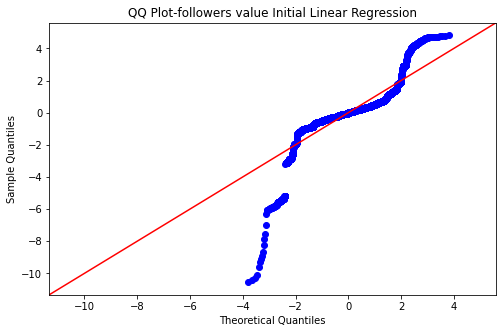

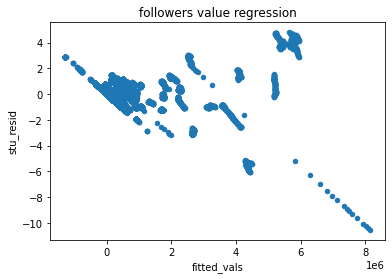

                              OLS Regression Results                             
Dep. Variable:     followers weekly_diff   R-squared:                       0.969
Model:                               OLS   Adj. R-squared:                  0.969
Method:                    Least Squares   F-statistic:                 4.278e+04
Date:                   Mon, 07 Dec 2020   Prob (F-statistic):               0.00
Time:                           06:09:05   Log-Likelihood:            -1.2230e+05
No. Observations:                  14922   AIC:                         2.446e+05
Df Residuals:                      14910   BIC:                         2.447e+05
Df Model:                             11                                         
Covariance Type:               nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

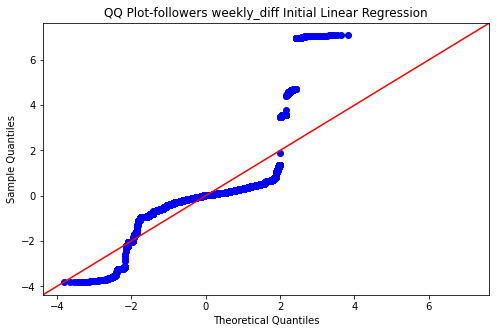

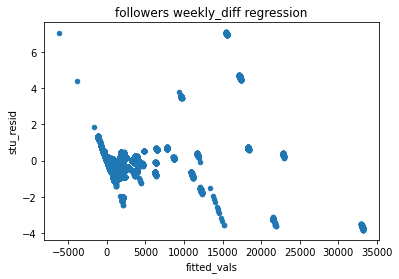

                                  OLS Regression Results                                 
Dep. Variable:     followers weekly_diff_percent   R-squared:                       0.788
Model:                                       OLS   Adj. R-squared:                  0.788
Method:                            Least Squares   F-statistic:                     5046.
Date:                           Mon, 07 Dec 2020   Prob (F-statistic):               0.00
Time:                                   06:09:06   Log-Likelihood:                 10176.
No. Observations:                          14922   AIC:                        -2.033e+04
Df Residuals:                              14910   BIC:                        -2.024e+04
Df Model:                                     11                                         
Covariance Type:                       nonrobust                                         
                                                         coef    std err          t      P>|t|      

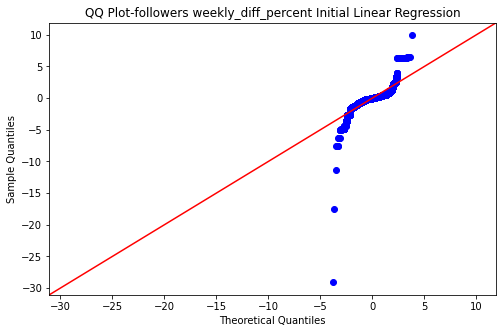

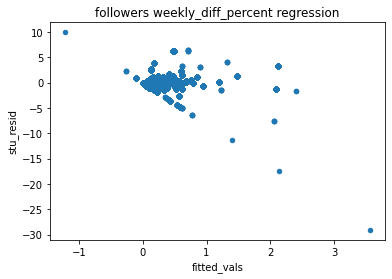

                                         OLS Regression Results                                        
Dep. Variable:     followers_to_listeners_ratio monthly_diff.3   R-squared:                       0.853
Model:                                                     OLS   Adj. R-squared:                  0.853
Method:                                          Least Squares   F-statistic:                     7871.
Date:                                         Mon, 07 Dec 2020   Prob (F-statistic):               0.00
Time:                                                 06:09:06   Log-Likelihood:                -4610.6
No. Observations:                                        14922   AIC:                             9245.
Df Residuals:                                            14910   BIC:                             9337.
Df Model:                                                   11                                         
Covariance Type:                                     nonrobust  

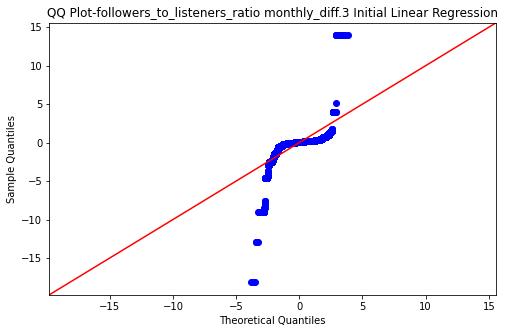

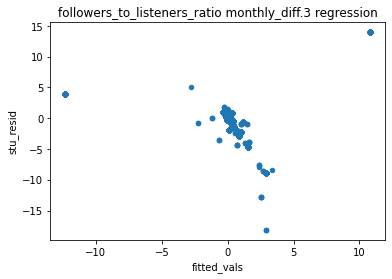

                                        OLS Regression Results                                        
Dep. Variable:     followers_to_listeners_ratio weekly_diff.3   R-squared:                       0.902
Model:                                                    OLS   Adj. R-squared:                  0.902
Method:                                         Least Squares   F-statistic:                 1.250e+04
Date:                                        Mon, 07 Dec 2020   Prob (F-statistic):               0.00
Time:                                                06:09:07   Log-Likelihood:                 6261.4
No. Observations:                                       14922   AIC:                        -1.250e+04
Df Residuals:                                           14910   BIC:                        -1.241e+04
Df Model:                                                  11                                         
Covariance Type:                                    nonrobust            

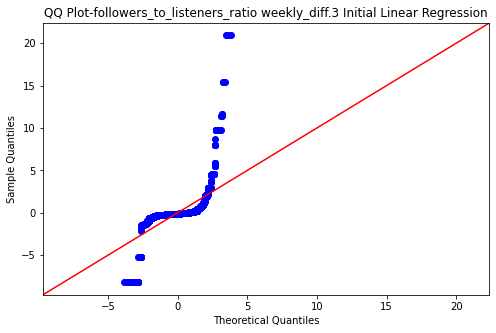

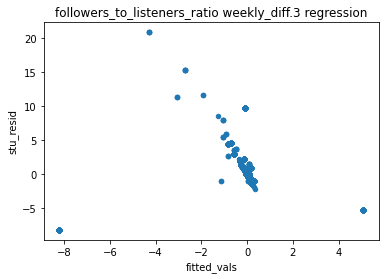

                                            OLS Regression Results                                            
Dep. Variable:     followers_to_listeners_ratio weekly_diff_percent.3   R-squared:                       0.971
Model:                                                            OLS   Adj. R-squared:                  0.971
Method:                                                 Least Squares   F-statistic:                 4.480e+04
Date:                                                Mon, 07 Dec 2020   Prob (F-statistic):               0.00
Time:                                                        06:09:07   Log-Likelihood:                -13384.
No. Observations:                                               14922   AIC:                         2.679e+04
Df Residuals:                                                   14910   BIC:                         2.688e+04
Df Model:                                                          11                                         
C

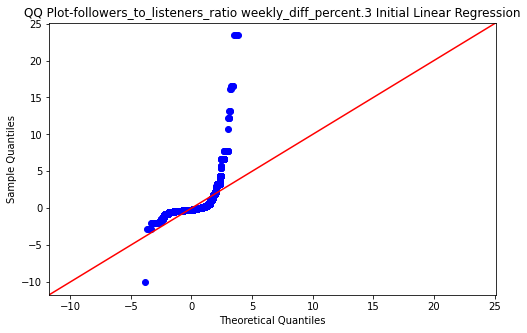

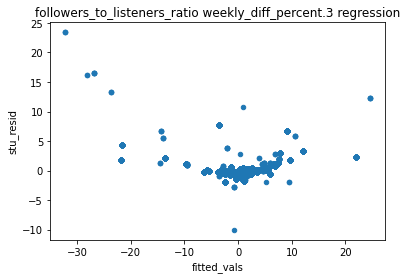

                            OLS Regression Results                            
Dep. Variable:      listeners value.2   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     4030.
Date:                Mon, 07 Dec 2020   Prob (F-statistic):               0.00
Time:                        06:09:08   Log-Likelihood:            -2.3240e+05
No. Observations:               14922   AIC:                         4.648e+05
Df Residuals:                   14910   BIC:                         4.649e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

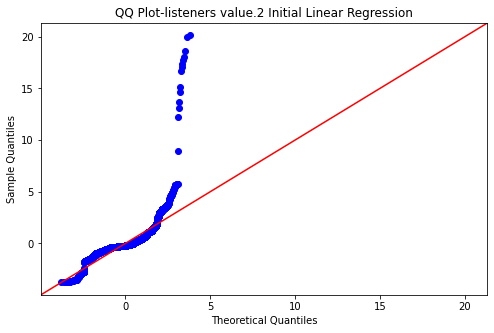

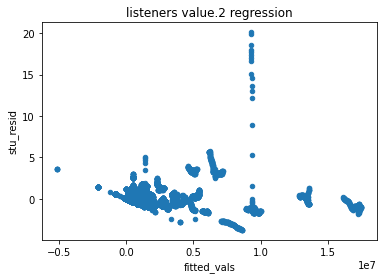

                                   OLS Regression Results                                  
Dep. Variable:     listeners weekly_diff_percent.2   R-squared:                       0.975
Model:                                         OLS   Adj. R-squared:                  0.975
Method:                              Least Squares   F-statistic:                 5.211e+04
Date:                             Mon, 07 Dec 2020   Prob (F-statistic):               0.00
Time:                                     06:09:08   Log-Likelihood:                -13471.
No. Observations:                            14922   AIC:                         2.697e+04
Df Residuals:                                14910   BIC:                         2.706e+04
Df Model:                                       11                                         
Covariance Type:                         nonrobust                                         
                                                         coef    std err        

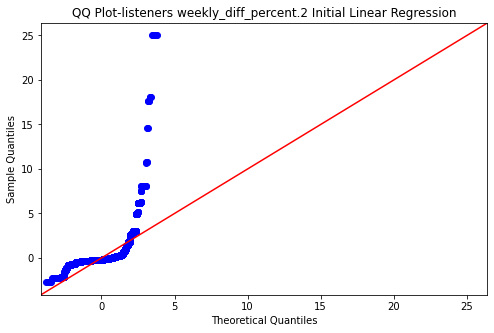

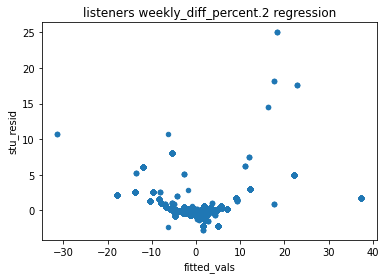

                               OLS Regression Results                               
Dep. Variable:     popularity weekly_diff.1   R-squared:                       0.854
Model:                                  OLS   Adj. R-squared:                  0.854
Method:                       Least Squares   F-statistic:                     7936.
Date:                      Mon, 07 Dec 2020   Prob (F-statistic):               0.00
Time:                              06:09:09   Log-Likelihood:                 8114.0
No. Observations:                     14922   AIC:                        -1.620e+04
Df Residuals:                         14910   BIC:                        -1.611e+04
Df Model:                                11                                         
Covariance Type:                  nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

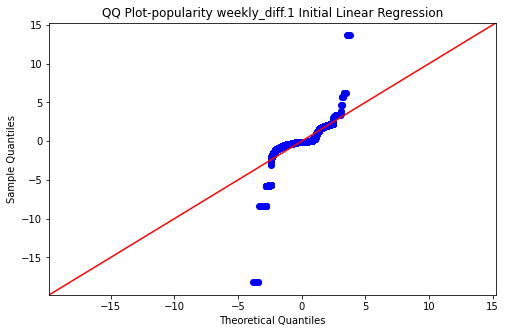

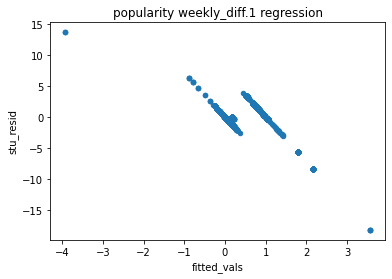

                                   OLS Regression Results                                   
Dep. Variable:     popularity weekly_diff_percent.1   R-squared:                       0.854
Model:                                          OLS   Adj. R-squared:                  0.854
Method:                               Least Squares   F-statistic:                     7934.
Date:                              Mon, 07 Dec 2020   Prob (F-statistic):               0.00
Time:                                      06:09:09   Log-Likelihood:                -1322.2
No. Observations:                             14922   AIC:                             2668.
Df Residuals:                                 14910   BIC:                             2760.
Df Model:                                        11                                         
Covariance Type:                          nonrobust                                         
                                                         coef    std e

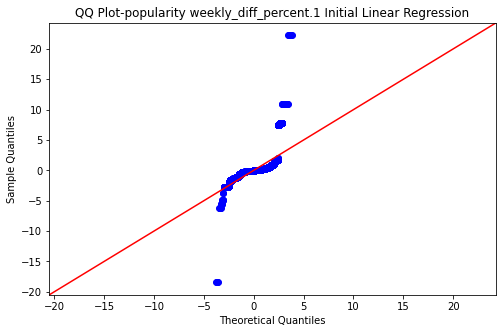

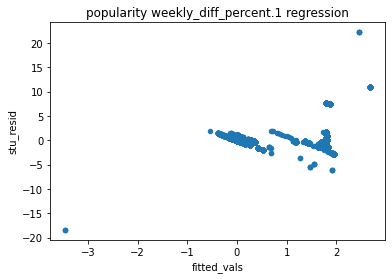

In [8]:
# regression
linear_regression_initial(dtrain)
# basic_logistic_regression(dtrain)

In [9]:
import os 
import psutil

process = psutil.Process(os.getpid())
process.memory_info()


pmem(rss=283971584, vms=1122619392, shared=54972416, text=3883008, lib=0, data=457973760, dirty=0)

In [10]:
import resource
resource.getrusage(resource.RUSAGE_SELF).ru_maxrss

277316